# Deep Q learning with Doom 🕹️
In this notebook we'll implement an agent <b>that plays Doom by using a Deep Q learning architecture.</b> <br>
Our agent playing Doom:



<img src="assets/doom.gif" style="max-width: 600px;" alt="Deep Q learning with Doom"/>


## For Google Collab

In [64]:
# %%bash
# # Install deps from
# # https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

# apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
# nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
# libopenal-dev timidity libwildmidi-dev unzip

# # Boost libraries
# apt-get install libboost-all-dev

# # Lua binding dependencies
# apt-get install liblua5.1-dev

## Install vizdoom, tensorflow and scikit-image

In [65]:
# !pip install vizdoom
# !pip install tensorflow
# !pip install scikit-image

## Step 1: Import the libraries 📚

In [66]:
import tensorflow as tf      # Deep Learning library
import tensorflow.keras as keras      # Deep Learning library
import numpy as np           # Handle matrices
from vizdoom import *        # Doom Environment

import random                # Handling random number generation
import time                  # Handling time calculation
from skimage import transform# Help us to preprocess the frames

from collections import deque# Ordered collection with ends
import matplotlib.pyplot as plt # Display graphs

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

## Step 2: Create our environment 🎮
- Now that we imported the libraries/dependencies, we will create our environment.
- Doom environment takes:
    - A `configuration file` that **handle all the options** (size of the frame, possible actions...)
    - A `scenario file`: that **generates the correct scenario** (in our case basic **but you're invited to try other scenarios**).
- Note: We have 3 possible actions `[[0,0,1], [1,0,0], [0,1,0]]` so we don't need to do one hot encoding (thanks to < a href="https://stackoverflow.com/users/2237916/silgon">silgon</a> for figuring out.

### Our environment
<img src="assets/doom.png" style="max-width:500px;" alt="Doom"/>

- A monster is spawned **randomly somewhere along the opposite wall**.
- Player can only go **left/right and shoot**.
- 1 hit is enough **to kill the monster**.
- Episode finishes when **monster is killed or on timeout (300)**.
<br><br>
REWARDS:

- +101 for killing the monster
- -5 for missing
- Episode ends after killing the monster or on timeout.
- living reward = -1

In [67]:
"""
Here we create our environment
"""
def create_environment():
    game = DoomGame()

    # Load the correct configuration
    game.load_config("basic.cfg")

    # Load the correct scenario (in our case basic scenario)
    game.set_doom_scenario_path("basic.wad")

    game.init()

    # Here our possible actions
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    possible_actions = [left, right, shoot]

    return game, possible_actions

"""
Here we performing random action to test the environment
"""
def test_environment():
    game = DoomGame()
    game.load_config("basic.cfg")
    game.set_doom_scenario_path("basic.wad")
    game.init()
    shoot = [0, 0, 1]
    left = [1, 0, 0]
    right = [0, 1, 0]
    actions = [shoot, left, right]

    episodes = 10
    for i in range(episodes):
        game.new_episode()
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            misc = state.game_variables
            action = random.choice(actions)
            print(action)
            reward = game.make_action(action)
            print ("\treward:", reward)
            time.sleep(0.02)
        print ("Result:", game.get_total_reward())
        time.sleep(2)
    game.close()

In [68]:
game, possible_actions = create_environment()

## Step 3: Define the preprocessing functions ⚙️
### preprocess_frame
Preprocessing is an important step, <b>because we want to reduce the complexity of our states to reduce the computation time needed for training.</b>
<br><br>
Our steps:
- Grayscale each of our frames (because <b> color does not add important information </b>). But this is already done by the config file.
- Crop the screen (in our case we remove the roof because it contains no information)
- We normalize pixel values
- Finally we resize the preprocessed frame

In [69]:
IMAGE_DIMS = (80, 80)

In [70]:
"""
    preprocess_frame:
    Take a frame.
    Resize it.
        __________________
        |                 |
        |                 |
        |                 |
        |                 |
        |_________________|

        to
        _____________
        |            |
        |            |
        |            |
        |____________|
    Normalize it.

    return preprocessed_frame

    """
def preprocess_frame(frame):
    # Greyscale frame already done in our vizdoom config
    # x = np.mean(frame,-1)

    # Crop the screen (remove the roof because it contains no information)
    # cropped_frame = frame[30:-10,30:-30]
    cropped_frame = frame[20:-20, 20:-20]

    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0

    # Resize
    preprocessed_frame = transform.resize(normalized_frame, IMAGE_DIMS)
    # plt.imshow(preprocessed_frame, interpolation='nearest')
    # plt.show()

    return preprocessed_frame

### stack_frames
👏 This part was made possible thanks to help of <a href="https://github.com/Miffyli">Anssi</a><br>

As explained in this really <a href="https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/">  good article </a> we stack frames.

Stacking frames is really important because it helps us to **give have a sense of motion to our Neural Network.**

- First we preprocess frame
- Then we append the frame to the deque that automatically **removes the oldest frame**
- Finally we **build the stacked state**

This is how work stack:
- For the first frame, we feed 4 frames
- At each timestep, **we add the new frame to deque and then we stack them to form a new stacked frame**
- And so on
<img src="https://raw.githubusercontent.com/simoninithomas/Deep_reinforcement_learning_Course/master/DQN/Space%20Invaders/assets/stack_frames.png" alt="stack">
- If we're done, **we create a new stack with 4 new frames (because we are in a new episode)**.

In [71]:
STACK_SIZE = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros(IMAGE_DIMS, dtype=np.int) for i in range(STACK_SIZE)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)

    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros(IMAGE_DIMS, dtype=np.int) for i in range(STACK_SIZE)], maxlen=4)

        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)

        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)

    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2)

    return stacked_state, stacked_frames

## Step 4: Set up our hyperparameters ⚗️
In this part we'll set up our different hyperparameters. But when you implement a Neural Network by yourself you will **not implement hyperparamaters at once but progressively**.

- First, you begin by defining the neural networks hyperparameters when you implement the model.
- Then, you'll add the training hyperparameters when you implement the training algorithm.

In [72]:
### MODEL HYPERPARAMETERS
state_size = [*IMAGE_DIMS, STACK_SIZE]          # Our input is a stack of 4 frames hence 84x84x4 (Width, height, channels)
action_size = game.get_available_buttons_size()              # 3 possible actions: left, right, shoot
learning_rate =  0.00015        # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 1000           # Total episodes for training
max_steps = 100                 # Max possible steps in an episode
batch_size = 64

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0             # exploration probability at start
explore_stop = 0.15             # minimum exploration probability
decay_rate = 0.000125           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size    # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000           # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False
checkpoint_path = "./models/model3/model.ckpt"

## Step 5: Create our Deep Q-learning Neural Network model 🧠
<img src="assets/model.png" alt="Model" />
This is our Deep Q-learning model:
- We take a stack of 4 frames as input
- It passes through 3 convnets
- Then it is flatened
- Finally it passes through 2 FC layers
- It outputs a Q value for each actions

In [73]:
class DQNetwork:
	def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
		self.state_size = state_size
		self.action_size = action_size
		self.learning_rate = learning_rate

		with tf.compat.v1.variable_scope(name):
		
			# We create the placeholders
			# *state_size means that we take each elements of state_size in tuple hence is like if we wrote
			# [None, IMAGE_SIZE.x, IMAGE_SIZE.y, 4]
			self.inputs_ = tf.compat.v1.placeholder(tf.float32, [None, *state_size], name="inputs")
			self.actions_ = tf.compat.v1.placeholder(tf.float32, [None, 3], name="actions_")

			# Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
			self.target_Q = tf.compat.v1.placeholder(tf.float32, [None], name="target")

			x = self.inputs_

			x = keras.layers.Conv2D(
				input_shape=(None, *state_size),
				filters = 32,
				strides = 2,
				kernel_size = (8, 8),
				activation = 'relu'
			)(x)
			
			x = keras.layers.MaxPooling2D(
				pool_size=(2, 2)
			)(x)

			x = keras.layers.Conv2D(
				input_shape=(None, *state_size),
				filters = 64,
				strides = 2,
				kernel_size = (7, 7),
				activation = 'relu'
			)(x)
			
			x = keras.layers.MaxPooling2D(
				pool_size=(2, 2)
			)(x)

			x = keras.layers.Flatten()(x)

			x = keras.layers.Dense(
				units = 128,
				activation = 'relu'
			)(x)
			
			self.output = keras.layers.Dense(
				units = action_size
			)(x)

			# Q is our predicted Q value.
			self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)


			# The loss is the difference between our predicted Q_values and the Q_target
			# Sum(Qtarget - Q)^2
			self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))

			self.optimizer = tf.compat.v1.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)


In [74]:
tf.compat.v1.disable_eager_execution()

In [75]:
# Reset the graph
tf.compat.v1.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

## Step 6: Experience Replay 🔁
Now that we create our Neural Network, **we need to implement the Experience Replay method.** <br><br>
Here we'll create the Memory object that creates a deque.A deque (double ended queue) is a data type that **removes the oldest element each time that you add a new element.**

This part was taken from Udacity : <a href="https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb" Cartpole DQN</a>

In [76]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)

        return [self.buffer[i] for i in index]

Here we'll **deal with the empty memory problem**: we pre-populate our memory by taking random actions and storing the experience (state, action, reward, new_state).

In [77]:
# Instantiate memory
memory = Memory(max_size = memory_size)

# Render the environment
game.new_episode()

for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        # First we need a state
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)

    # Random action
    action = random.choice(possible_actions)

    # Get the rewards
    reward = game.make_action(action)

    # Look if the episode is finished
    done = game.is_episode_finished()

    # If we're dead
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)

        # Add experience to memory
        memory.add((state, action, reward, next_state, done))

        # Start a new episode
        game.new_episode()

        # First we need a state
        state = game.get_state().screen_buffer

        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)

    else:
        # Get the next state
        next_state = game.get_state().screen_buffer
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

        # Add experience to memory
        memory.add((state, action, reward, next_state, done))

        # Our state is now the next_state
        state = next_state

## Step 7: Set up Tensorboard 📊
For more information about tensorboard, please watch this <a href="https://www.youtube.com/embed/eBbEDRsCmv4">excellent 30min tutorial</a> <br><br>
To launch tensorboard : `tensorboard --logdir=/tensorboard/dqn/1`

In [78]:
# Setup TensorBoard Writer
writer = tf.compat.v1.summary.FileWriter("/tensorboard/dqn/1")

## Losses
tf.compat.v1.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.compat.v1.summary.merge_all()

## Step 8: Train our Agent 🏃‍♂️

Our algorithm:
<br>
* Initialize the weights
* Init the environment
* Initialize the decay rate (that will use to reduce epsilon)
<br><br>
* **For** episode to max_episode **do**
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br><br>
    * **While** step < max_steps **do**:
        * Increase decay_rate
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set $\hat{Q} = r$ if the episode ends at $+1$, otherwise set $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$
    * **endfor**
    <br><br>
* **endfor**



In [79]:
"""
This function will do the part
With Ïµ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)

    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = random.choice(possible_actions)

    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})

        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]

    return action, explore_probability

In [80]:
import os
num_threads = 5
os.environ["OMP_NUM_THREADS"] = "5"
os.environ["TF_NUM_INTRAOP_THREADS"] = "5"
os.environ["TF_NUM_INTEROP_THREADS"] = "5"
tf.compat.v1.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.compat.v1.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.compat.v1.config.set_soft_device_placement(True)

In [81]:
# Saver will help us to save our model
saver = tf.compat.v1.train.Saver()

if training == True:
    with tf.compat.v1.Session() as sess:
        saver.restore(sess, checkpoint_path)
        
        # Initialize the variables
        sess.run(tf.compat.v1.global_variables_initializer())
        
        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0

        # Init the game
        game.init()

        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            game.new_episode()
            state = game.get_state().screen_buffer
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)

            while step < max_steps:
                step += 1
                
                # Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)

                # Do the action
                reward = game.make_action(action)

                # Look if the episode is finished
                done = game.is_episode_finished()
                
                # Add the reward to total reward
                episode_rewards.append(reward)

                # If the game is finished
                if done:
                    # the episode ends so no next state
                    next_state = np.zeros((84,84), dtype=np.int)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                              'Total reward: {}'.format(total_reward),
                              'Training loss: {:.4f}'.format(loss),
                              'Explore P: {:.4f}'.format(explore_probability))

                    memory.add((state, action, reward, next_state, done))

                else:
                    # Get the next state
                    next_state = game.get_state().screen_buffer
                    
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    

                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))
                    
                    # st+1 is now our current state
                    state = next_state


                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                 # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                    feed_dict={DQNetwork.inputs_: states_mb,
                                               DQNetwork.target_Q: targets_mb,
                                               DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 10 episodes
            if (episode + 1) % 10 == 0:
                save_path = saver.save(sess, checkpoint_path)
                print("Model Saved")

## Step 9: Watch our Agent play 👀
Now that we trained our agent, we can test it

In [89]:
num_test = 100
scores = []

with tf.compat.v1.Session() as sess:
    game, possible_actions = create_environment()

    totalScore = 0

    # Load the model
    saver.restore(sess, checkpoint_path)
    game.init()
    for i in range(num_test):

        done = False

        game.new_episode()

        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)

        while not game.is_episode_finished():
            # Take the biggest Q value (= the best action)
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})

            # Take the biggest Q value (= the best action)
            choice = np.argmax(Qs)
            action = possible_actions[int(choice)]

            game.make_action(action)
            done = game.is_episode_finished()
            score = game.get_total_reward()

            if done:
                break

            else:
                next_state = game.get_state().screen_buffer
                next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                state = next_state

        score = game.get_total_reward()
        scores.append(score)
        print("Score: ", score)
    game.close()

INFO:tensorflow:Restoring parameters from ./models/model3/model.ckpt
Score:  94.0
Score:  94.0
Score:  94.0
Score:  83.0
Score:  94.0
Score:  71.0
Score:  94.0
Score:  90.0
Score:  63.0
Score:  88.0
Score:  61.0
Score:  92.0
Score:  44.0
Score:  83.0
Score:  94.0
Score:  62.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  89.0
Score:  63.0
Score:  94.0
Score:  94.0
Score:  88.0
Score:  69.0
Score:  94.0
Score:  94.0
Score:  53.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  70.0
Score:  94.0
Score:  94.0
Score:  63.0
Score:  94.0
Score:  64.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  83.0
Score:  88.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  94.0
Score:  44.0
Score:  94.0
Score:  47.0
Score:  94.0
Score:  70.0
Score:  88.0
Score:  94.0
Score:  94.0
Score:  88.0
Score:  94.0
Score:  63.0
Score:  94.0
Score:  94.0
Score:  88.0
Score:  94.0
Score:  50.0
Score:  94.0
Score:  49.0
Score:  69.0
Score:  69.0
Score:  

Average:	 82.34
Min Score:	 42.0
Max Score:	 94.0


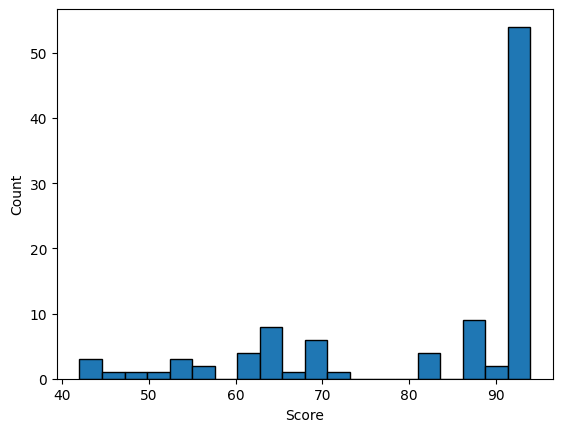

In [90]:
#create histogram
plt.hist(scores, ec='black', bins=20)
plt.xlabel("Score")
plt.ylabel("Count")

average =  sum(scores) / len(scores)
min_score = min(scores)
max_score = max(scores)
print("Average:\t", average)
print("Min Score:\t", min_score)
print("Max Score:\t", max_score)